In [0]:
import gc
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import lightgbm as lgb

In [0]:
!pip install keras==2.2.4

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dtype = {
    'id': str,
    'teacher_id': str,
    'teacher_prefix': str,
    'school_state': str,
    'project_submitted_datetime': str,
    'project_grade_category': str,
    'project_subject_categories': str,
    'project_subject_subcategories': str,
    'project_title': str,
    'project_essay_1': str,
    'project_essay_2': str,
    'project_essay_3': str,
    'project_essay_4': str,
    'project_resource_summary': str,
    'teacher_number_of_previously_posted_projects': int,
    'project_is_approved': np.uint8,
}
 

train = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/train.csv',dtype=dtype, low_memory=True)
res = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/resources.csv',dtype=dtype, low_memory=True)
test = pd.read_csv('/content/gdrive/Shared drives/Predictive Analytics Project/Data/Original Dataset/test.csv',dtype=dtype, low_memory=True)

In [0]:
print(train.head())
# print(test.head())
print(train.shape, test.shape)

        id  ... project_is_approved
0  p036502  ...                   1
1  p039565  ...                   0
2  p233823  ...                   1
3  p185307  ...                   0
4  p013780  ...                   1

[5 rows x 16 columns]
(182080, 16) (78035, 15)


In [0]:
# Preprocess data
train['project_essay'] = train.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_essay_3']), 
    str(row['project_essay_4']),
    ]), axis=1)
test['project_essay'] = test.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_essay_3']), 
    str(row['project_essay_4']),
    ]), axis=1)

In [0]:
# Extract features
def extract_features(df):
    df['project_title_len'] = df['project_title'].apply(lambda x: len(str(x)))
    df['project_essay_1_len'] = df['project_essay_1'].apply(lambda x: len(str(x)))
    df['project_essay_2_len'] = df['project_essay_2'].apply(lambda x: len(str(x)))
    df['project_essay_3_len'] = df['project_essay_3'].apply(lambda x: len(str(x)))
    df['project_essay_4_len'] = df['project_essay_4'].apply(lambda x: len(str(x)))
    df['project_resource_summary_len'] = df['project_resource_summary'].apply(lambda x: len(str(x)))
    
    df['project_title_wc'] = df['project_title'].apply(lambda x: len(str(x).split(' ')))
    df['project_essay_1_wc'] = df['project_essay_1'].apply(lambda x: len(str(x).split(' ')))
    df['project_essay_2_wc'] = df['project_essay_2'].apply(lambda x: len(str(x).split(' ')))
    df['project_essay_3_wc'] = df['project_essay_3'].apply(lambda x: len(str(x).split(' ')))
    df['project_essay_4_wc'] = df['project_essay_4'].apply(lambda x: len(str(x).split(' ')))
    df['project_resource_summary_wc'] = df['project_resource_summary'].apply(lambda x: len(str(x).split(' ')))
  
extract_features(train)
extract_features(test)

train.drop([
    'project_essay_1', 
    'project_essay_2', 
    'project_essay_3', 
    'project_essay_4'], axis=1, inplace=True)
test.drop([
    'project_essay_1', 
    'project_essay_2', 
    'project_essay_3', 
    'project_essay_4'], axis=1, inplace=True)

df_all = pd.concat([train, test], axis=0)
gc.collect()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



0

In [0]:
#Accepted projects counter (gave imrovement on CV but worse on LB, need to be implemented withing a CV loop with splitting data by time)
df_all['project_is_approved'].fillna(0, inplace=True)
cumsums = df_all[
            ['id', 
            'teacher_id', 
            'project_submitted_datetime', 
            'project_is_approved']].\
        sort_values('project_submitted_datetime').\
        groupby(['teacher_id']).agg({'project_is_approved': lambda x: x.shift().sum(), 'id': 'first'}).fillna(0).\
        groupby(level=0).agg({'project_is_approved': 'cumsum', 'id': 'first'}).reset_index()
cumsums = pd.DataFrame(cumsums)
cumsums.rename(columns={'project_is_approved': 'teacher_number_of_previously_accepted_projects'}, inplace=True)
print(cumsums.head())
train = train.merge(cumsums, on=['id', 'teacher_id'], how='left')
test = test.merge(cumsums, on=['id', 'teacher_id'], how='left')

train['approve_rate'] = (train['teacher_number_of_previously_accepted_projects'] + 5)/\
    (train['teacher_number_of_previously_posted_projects'] + 10)
test['approve_rate'] = (test['teacher_number_of_previously_accepted_projects'] + 5)/\
    (test['teacher_number_of_previously_posted_projects'] + 10)

print(train.head())
print(test.head())

                         teacher_id  ...       id
0  00000f7264c27ba6fea0c837ed6aa0aa  ...  p218094
1  00002d44003ed46b066607c5455a999a  ...  p043940
2  00006084c3d92d904a22e0a70f5c119a  ...  p256622
3  0000a9af8b6b9cc9e41f53322a8b8cf1  ...  p145953
4  0000d4777d14b33a1406dd6c9019fe89  ...  p012597

[5 rows x 3 columns]
        id  ... approve_rate
0  p036502  ...          NaN
1  p039565  ...     0.454545
2  p233823  ...          NaN
3  p185307  ...          NaN
4  p013780  ...          NaN

[5 rows x 27 columns]
        id  ... approve_rate
0  p233245  ...     0.416667
1  p096795  ...     0.454545
2  p236235  ...     0.500000
3  p233680  ...          NaN
4  p171879  ...     0.727273

[5 rows x 26 columns]


In [0]:
cumsums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132133 entries, 0 to 132132
Data columns (total 3 columns):
teacher_id                                        132133 non-null object
teacher_number_of_previously_accepted_projects    132133 non-null float64
id                                                132133 non-null object
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


In [0]:
cumsums.head(3)

,teacher_id,teacher_number_of_previously_accepted_projects,id
0,00000f7264c27ba6fea0c837ed6aa0aa,0.0,p218094
1,00002d44003ed46b066607c5455a999a,3.0,p043940
2,00006084c3d92d904a22e0a70f5c119a,1.0,p256622


In [0]:
train.info()

In [0]:
train.head(3)

In [0]:
test.info()

In [0]:
test.head(3)

In [0]:
# Merge with resources
res = pd.DataFrame(res[['id', 'quantity', 'price']].groupby('id').agg(\
    {
        'quantity': [
            'sum',
            'min', 
            'max', 
            'mean', 
            'std', 
            # lambda x: len(np.unique(x)),
        ],
        'price': [
            'count', 
            'sum', 
            'min', 
            'max', 
            'mean', 
            'std', 
            lambda x: len(np.unique(x)),
        ]}
    )).reset_index()
res.columns = ['_'.join(col) for col in res.columns]
res.rename(columns={'id_': 'id'}, inplace=True)
res['mean_price'] = res['price_sum']/res['quantity_sum']
# res['price_max_to_price_min'] = res['price_max']/res['price_min']
# res['quantity_max_to_quantity_min'] = res['quantity_max']/res['quantity_min']

print(res.head())
train = train.merge(res, on='id', how='left')
test = test.merge(res, on='id', how='left')
del res
gc.collect()

        id  quantity_sum  ...  price_<lambda_0>  mean_price
0  p000001             7  ...               4.0   65.651429
1  p000002            21  ...              13.0   24.566190
2  p000003             4  ...               3.0   74.742500
3  p000004            98  ...              36.0   11.364184
4  p000005             8  ...               2.0   60.748750

[5 rows x 14 columns]


11

In [0]:
train.head(3)

In [0]:
# Preprocess columns with label encoder
print('Label Encoder...')
cols = [
    'teacher_id', 
    'teacher_prefix', 
    'school_state', 
    'project_grade_category', 
    'project_subject_categories', 
    'project_subject_subcategories'
]

for c in tqdm(cols):
    le = LabelEncoder()
    le.fit(df_all[c].astype(str))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))
del le
gc.collect()
print('Done.')


  0%|          | 0/6 [00:00<?, ?it/s]

Label Encoder...


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]

Done.


In [0]:
train.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_essay,project_title_len,project_essay_1_len,project_essay_2_len,project_essay_3_len,project_essay_4_len,project_resource_summary_len,project_title_wc,project_essay_1_wc,project_essay_2_wc,project_essay_3_wc,project_essay_4_wc,project_resource_summary_wc,teacher_number_of_previously_accepted_projects,approve_rate,quantity_sum,quantity_min,quantity_max,quantity_mean,quantity_std,price_count,price_sum,price_min,price_max,price_mean,price_std,price_<lambda_0>,mean_price
0,p036502,37239,3,33,2016-11-18 14:45:59,3,24,328,Super Sight Word Centers,My students need 6 Ipod Nano's to create and d...,26,1,Most of my kindergarten students come from low...,24,967,805,3,3,127,4,170,142,1,1,21,NaN,NaN,6,3,3,3.0,0.0,2,299.98,149.99,149.99,149.99,0.0,1.0,49.996667
1,p039565,115331,2,10,2017-04-26 15:57:28,0,42,400,Keep Calm and Dance On,My students need matching shirts to wear for d...,1,0,Our elementary school is a culturally rich sch...,22,587,639,3,3,81,5,94,102,1,1,12,0.0,0.454545,20,20,20,20.0,NaN,1,20.00,20.00,20.00,20.00,NaN,1.0,1.000000
2,p233823,87678,3,44,2017-01-01 22:57:44,0,36,17,Lets 3Doodle to Learn,My students need the 3doodler. We are an SEM s...,5,1,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,21,761,546,3,3,186,4,135,101,1,1,33,NaN,NaN,1,1,1,1.0,NaN,1,469.99,469.99,469.99,469.99,NaN,1.0,469.990000


In [0]:
# Preprocess timestamp
print('Preprocessing timestamp...')
def process_timestamp(df):
    df['year'] = df['project_submitted_datetime'].apply(lambda x: int(x.split('-')[0]))
    df['month'] = df['project_submitted_datetime'].apply(lambda x: int(x.split('-')[1]))
    df['date'] = df['project_submitted_datetime'].apply(lambda x: int(x.split(' ')[0].split('-')[2]))
    df['day_of_week'] = pd.to_datetime(df['project_submitted_datetime']).dt.weekday
    df['hour'] = df['project_submitted_datetime'].apply(lambda x: int(x.split(' ')[-1].split(':')[0]))
    df['minute'] = df['project_submitted_datetime'].apply(lambda x: int(x.split(' ')[-1].split(':')[1]))
    df['project_submitted_datetime'] = pd.to_datetime(df['project_submitted_datetime']).values.astype(np.int64)

process_timestamp(train)
process_timestamp(test)
print('Done.')

Preprocessing timestamp...
Done.


In [0]:
# Preprocess text
print('Preprocessing text...')
cols = [
    'project_title', 
    'project_essay', 
    'project_resource_summary'
]
n_features = [
    400, 
    4040, 
    400,
]

for c_i, c in tqdm(enumerate(cols)):
    tfidf = TfidfVectorizer(
        max_features=n_features[c_i],
        norm='l2',
        )
    tfidf.fit(df_all[c])
    tfidf_train = np.array(tfidf.transform(train[c]).toarray(), dtype=np.float16)
    tfidf_test = np.array(tfidf.transform(test[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c_i]):
        train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]
        
    del tfidf, tfidf_train, tfidf_test
    gc.collect()
    
print('Done.')
del df_all
gc.collect()

0it [00:00, ?it/s]

Preprocessing text...


1it [00:05,  5.61s/it]

In [0]:
# Prepare data
cols_to_drop = [
    'id',
    'teacher_id',
    'project_title', 
    'project_essay', 
    'project_resource_summary',
    'project_is_approved',
]
X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train['project_is_approved']
X_test = test.drop(cols_to_drop, axis=1, errors='ignore')
id_test = test['id'].values
feature_names = list(X.columns)
print(X.shape, X_test.shape)

del train, test
gc.collect()

(182080, 4878) (78035, 4878)


0

In [0]:
# Build the model
cnt = 0
p_buf = []
n_splits = 3
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=0)
auc_buf = []   

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 12,
        'num_leaves': 28,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': 1,
        'lambda_l2': 1.0,
        'min_gain_to_split': 0,
    }  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index],
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
            
        del importance, model_fnames, tuples

    p = model.predict(X.loc[valid_index], num_iteration=model.best_iteration)
    auc = roc_auc_score(y.loc[valid_index], p)

    print('{} AUC: {}'.format(cnt, auc))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    auc_buf.append(auc)

    cnt += 1
    if cnt > 0: # Comment this to run several folds
        break
    
    del model, lgb_train, lgb_valid, p
    gc.collect

auc_mean = np.mean(auc_buf)
auc_std = np.std(auc_buf)
print('AUC = {:.6f} +/- {:.6f}'.format(auc_mean, auc_std))

Fold 1/3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.766992	valid_1's auc: 0.749549
[200]	training's auc: 0.798037	valid_1's auc: 0.764917
[300]	training's auc: 0.817734	valid_1's auc: 0.771918
[400]	training's auc: 0.833036	valid_1's auc: 0.775705
[500]	training's auc: 0.845459	valid_1's auc: 0.777767
[600]	training's auc: 0.856284	valid_1's auc: 0.779143
[700]	training's auc: 0.865911	valid_1's auc: 0.780059
[800]	training's auc: 0.874811	valid_1's auc: 0.781113
[900]	training's auc: 0.882835	valid_1's auc: 0.781445
[1000]	training's auc: 0.890194	valid_1's auc: 0.781947
[1100]	training's auc: 0.897382	valid_1's auc: 0.782155
[1200]	training's auc: 0.903822	valid_1's auc: 0.782291
[1300]	training's auc: 0.910321	valid_1's auc: 0.782363
[1400]	training's auc: 0.916076	valid_1's auc: 0.782479
[1500]	training's auc: 0.921486	valid_1's auc: 0.782702
[1600]	training's auc: 0.926476	valid_1's auc: 0.78264
Early stopping, best iteration is:
[1538]	

In [0]:
print(model.feature_importance())

[ 24  79 258 ...   7   7   5]


In [0]:
X.columns

Index(['teacher_prefix', 'school_state', 'project_submitted_datetime',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'project_title_len',
       'project_essay_1_len', 'project_essay_2_len',
       ...
       'project_resource_summary_tfidf_390',
       'project_resource_summary_tfidf_391',
       'project_resource_summary_tfidf_392',
       'project_resource_summary_tfidf_393',
       'project_resource_summary_tfidf_394',
       'project_resource_summary_tfidf_395',
       'project_resource_summary_tfidf_396',
       'project_resource_summary_tfidf_397',
       'project_resource_summary_tfidf_398',
       'project_resource_summary_tfidf_399'],
      dtype='object', length=4878)

In [0]:
preds = p_buf/cnt

In [0]:
subm = pd.DataFrame()
subm['id'] = id_test
subm['project_is_approved'] = preds
subm.to_csv('submission.csv', index=False)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/Predictive Analytics Project/Data/lgbm_importances-01.png')
    plt.show()

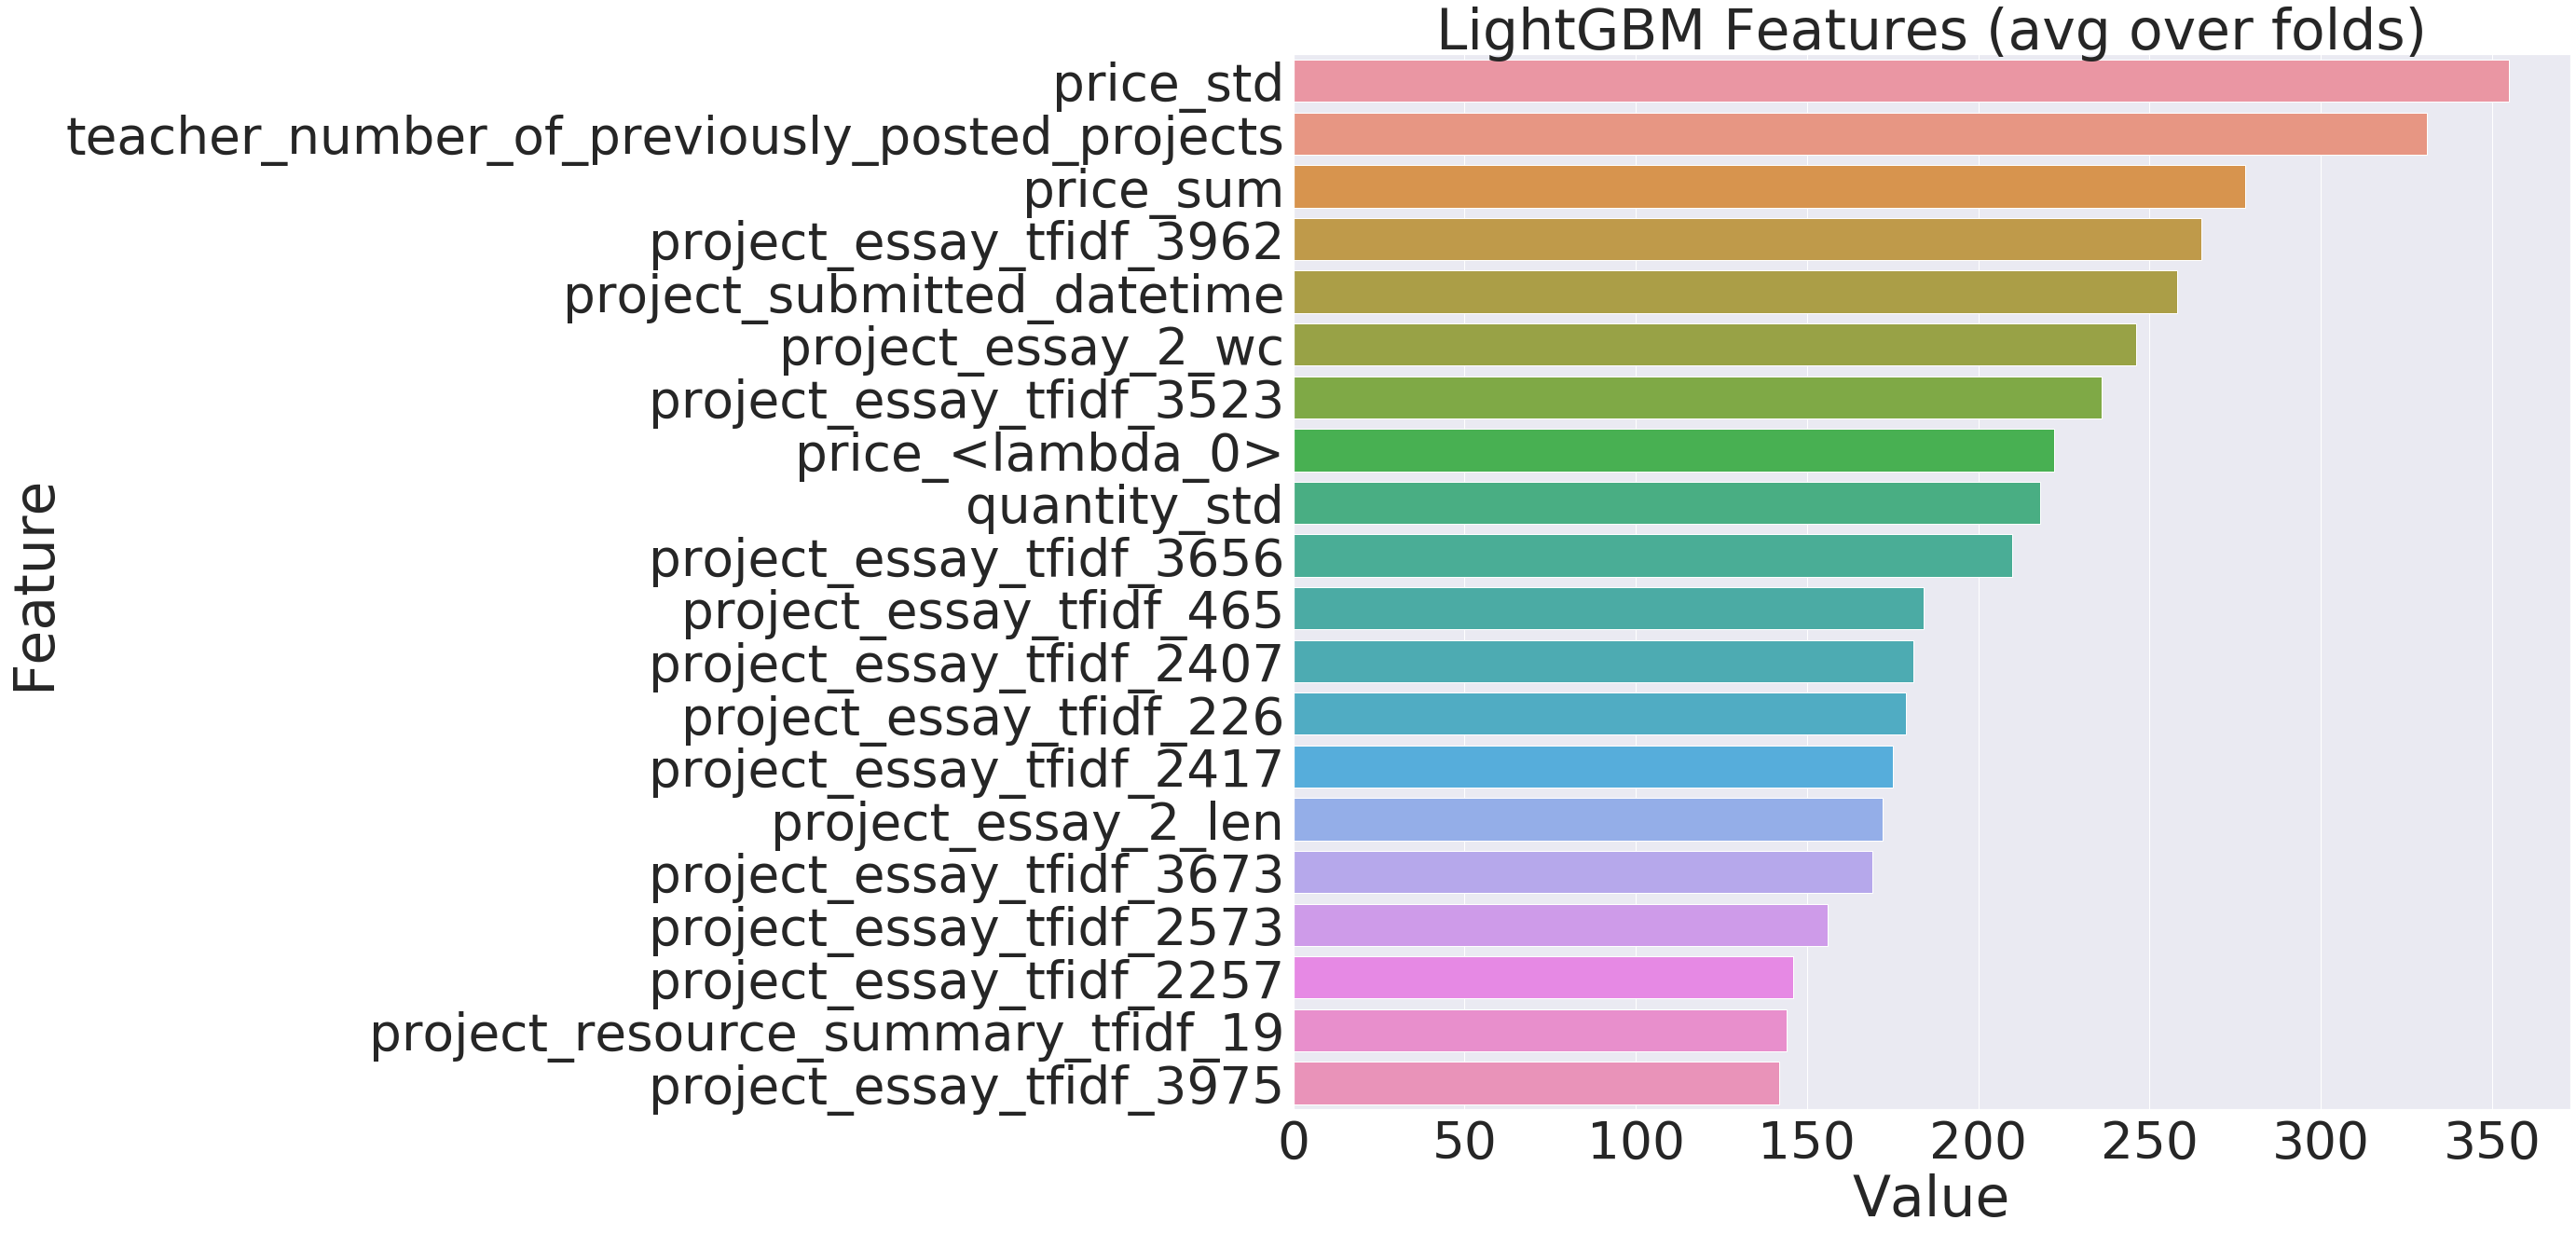

In [0]:
plotImp(model, X, num=20)

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

In [0]:
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)